# Lecture 2: Feature Map, Decision Tree, and Random Forest

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(123)

## Feature Maps

Feature maps are used to transform a feature into a vector of features. A non-linear feature map combined with a linear model can be used to approximate a non-linear relationship between the original features and the target.

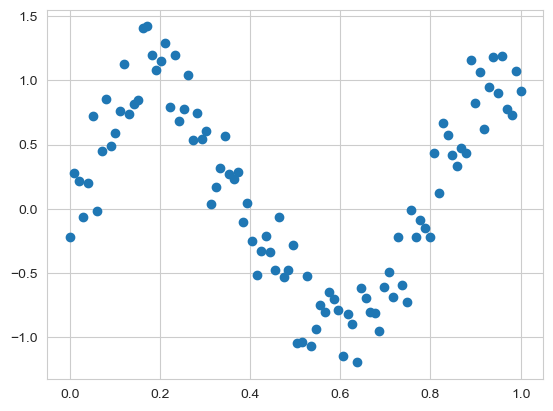

In [2]:

x = np.linspace(0, 1, 100)
y = np.sin(8 * x) + np.random.normal(0, 0.2, 100)

plt.plot(x, y, 'o' )
plt.show()

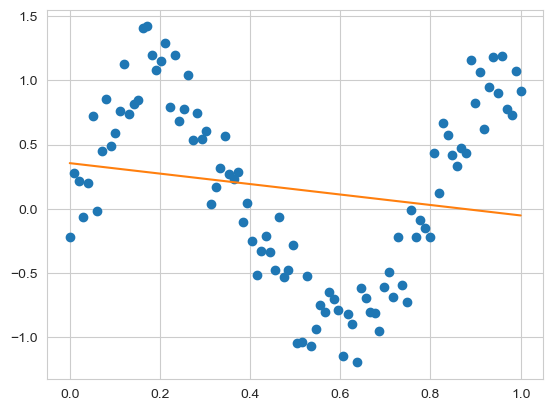

In [3]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression().fit(x.reshape(-1, 1), y)
p = linreg.predict(x.reshape(-1, 1))
plt.plot(x, y, 'o')
plt.plot(x, p, '-')
plt.show()

In [4]:
def mse(y, p):
    return np.mean((y - p)**2)

mse(y, p)

0.4908817504159984

### Polynomial Features

For a feature $x\in\mathbb{R}$, the polynomial feature map of degree $d$ is defined as
$$
\phi_d(x) = (1, x, x^2, \ldots, x^d)
$$

For multiple features $x\in\mathbb{R}^n$, the polynomial feature map of degree 2 is defined as
$$
\phi_2(x) = (1, x_1, x_2, \ldots, x_n, x_1^2, x_1x_2, \ldots, x_1x_n, x_2^2, x_2x_3, \ldots, x_{n-1}x_n, x_n^2)
$$

In the most general case, for $x\in\mathbb{R}^n$, $\phi_d(x)$ will be a vector containing all possible values of $$\prod_{i=1}^n x_i^{d_i}$$ where $0\le d_i\le d$ and $\sum_{i=1}^n d_i \le d$.

In [ ]:
phi = PolynomialFeatures(3).fit_transform(x.reshape(-1, 1))
plt.plot(x, phi, '-')

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

plt.figure(figsize=(10, 8))
plt.plot(x, y, 'o', label='data')

for deg in [2, 3, 4, 100]:
    phi = PolynomialFeatures(deg).fit_transform(x.reshape(-1, 1))
    p = LinearRegression().fit(phi, y).predict(phi)
    print(f'deg={deg}, mse={mse(y, p):.3f}')
    plt.plot(x, p, '-', label=f'deg={deg}')

plt.legend()
plt.show()

### Radial Basis Features

$$ x \rightarrow \phi(x) = (1, \exp(-\gamma\|x-\mu_1\|^2), \exp(-\gamma\|x-\mu_2\|^2), \ldots, \exp(-\gamma\|x-\mu_k\|^2)) $$

where $\mu_1, \mu_2, \ldots, \mu_k$ are the centers of the radial basis functions and $\gamma$ is the width of the radial basis functions.

In [ ]:
from sklearn.kernel_approximation import Nystroem

rbf = Nystroem('rbf', gamma=10, n_components=4, random_state=0)
phi = rbf.fit_transform(x.reshape(-1, 1))
plt.plot(x, phi, '-')
plt.legend(['basis1', 'basis2', 'basis3', 'basis4'])
plt.xticks(rbf.components_.flatten())
plt.show()

In [ ]:
for i in range(5):
    print(x[i], '->', phi[i])

In [ ]:
phi.shape

In [ ]:
p = LinearRegression().fit(phi, y).predict(phi)
plt.plot(x, y, 'o')
plt.plot(x, p, '-')
plt.show()

mse(y, p)

## Decision Trees

### For Classification

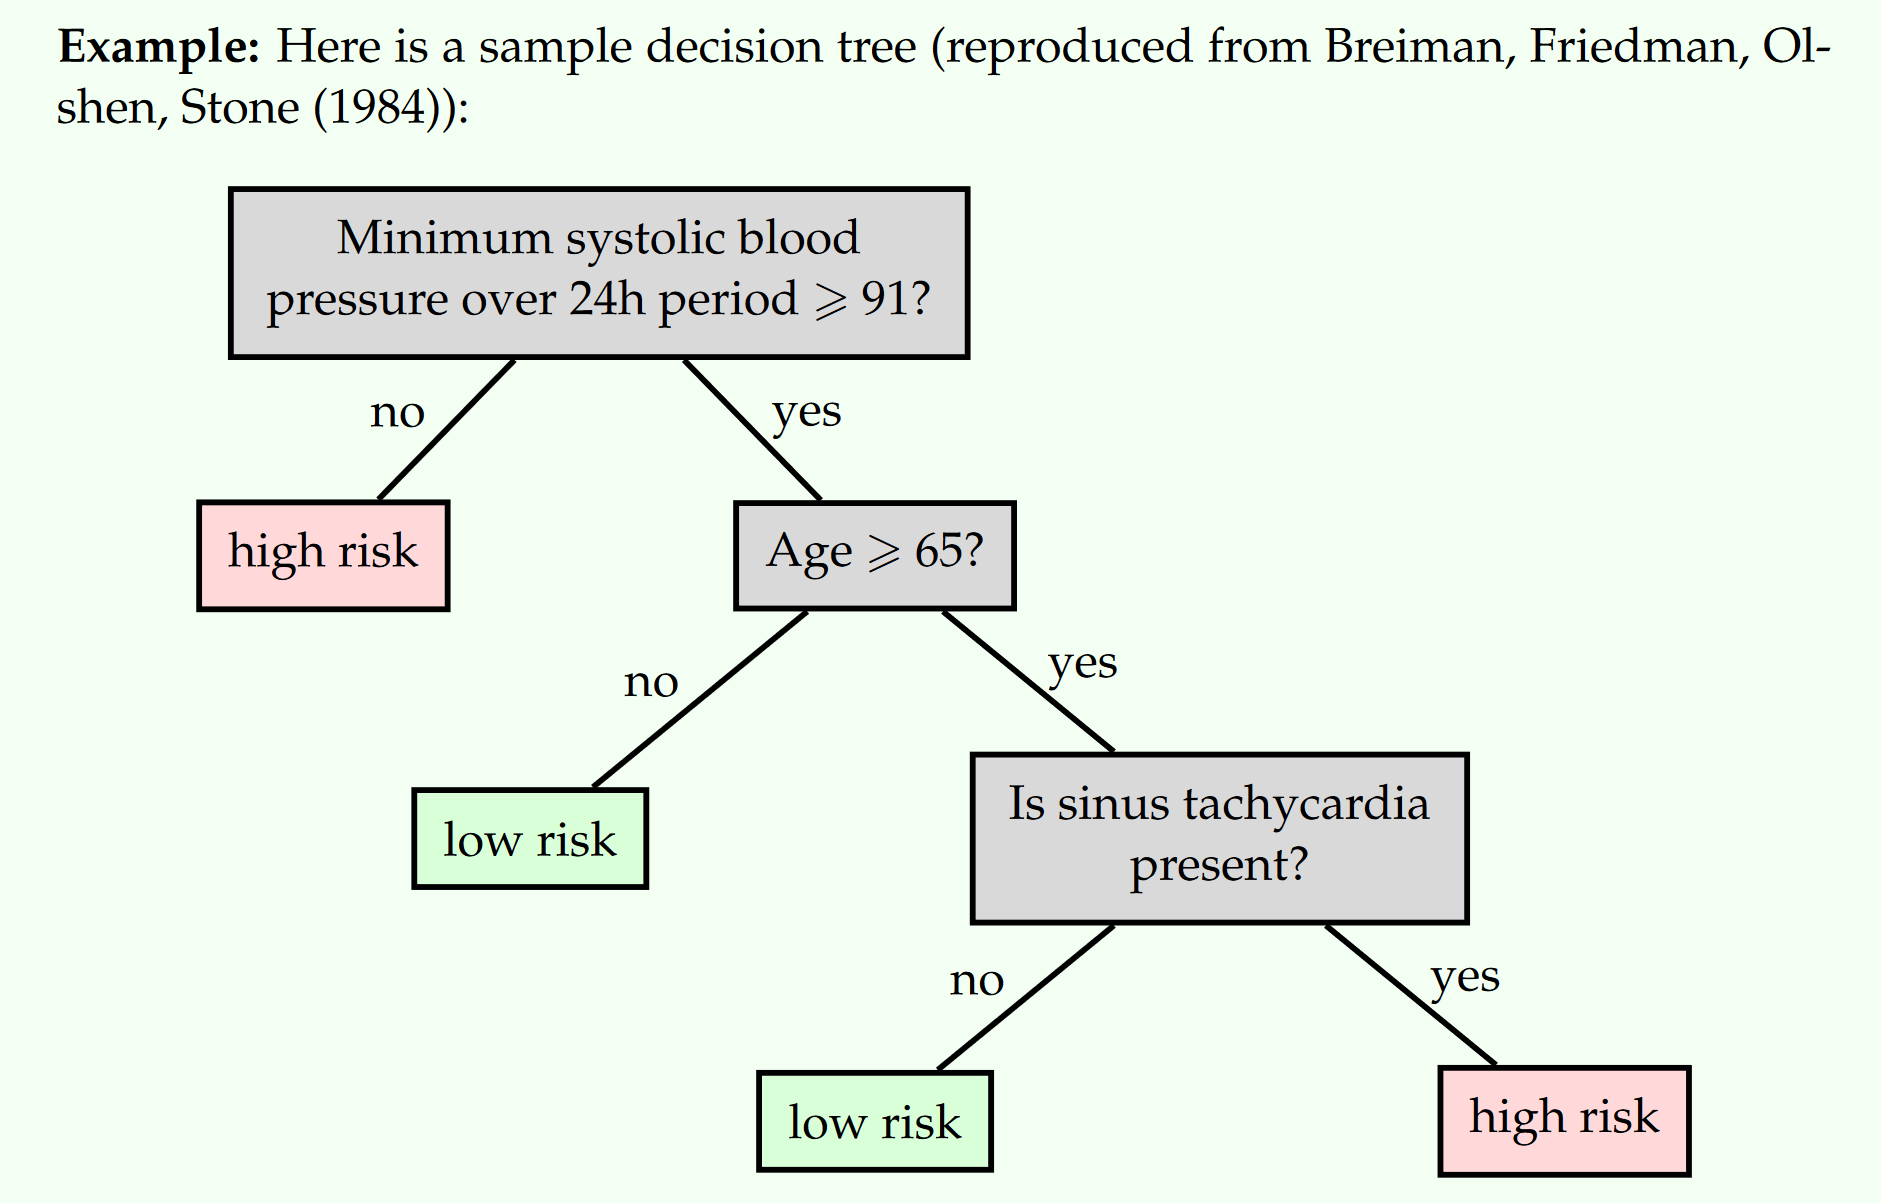

In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

X, y = load_iris(return_X_y=True, as_frame=True)
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X.head()

In [ ]:
y.value_counts()

In [ ]:
labels = load_iris()['target_names']

In [ ]:
labels[y]

#### How to split?

Entropy: 
$$H(X) = -\sum_{i=1}^n p_i \log_2 p_i$$

Gini index: 
$$Gini(D_p) = 1 - \sum_{i=1}^n p_i^2$$

Split gain:
$$Gain(D, f) = f(D) - \sum_{j=1}^m \frac{|D_j|}{|D|} f(D_j)$$
$f\in\{H, Gini, \ldots\}.$ For binary trees, $m=2$.

Split to maximize the split gain.

In [ ]:
x = np.random.choice(12, 100)
x

In [ ]:
p = np.array([len(x[x == i]) / len(x) for i in range(6)])
-sum(p * np.log2(p))

In [ ]:
def split(vals, threshold):
    return vals <= threshold, vals > threshold

def find_splits(X: pd.DataFrame):
    return {
        col: sorted(vals.unique())[:-1]
        for col, vals in X.iteritems()
    }

def entropy(y):
    p = y.value_counts() / len(y)
    return -np.sum(p * np.log2(p))

def gini(y):
    p = y.value_counts() / len(y)
    return 1 - np.sum(p**2)

def gain(full, left, right, criterion):
    p_left = len(left) / len(full)
    p_right = len(right) / len(full)
    return criterion(full) - p_left * criterion(left) - p_right * criterion(right)

def find_best_split(X, y, criterion):
    """Find the best split that reduces the most uncertainty or impurity."""
    splits = find_splits(X)
    best_gain = -np.inf
    best_col = None
    best_threshold = None
    for col, thresholds in splits.items():
        for threshold in thresholds:
            left, right = split(X[col], threshold)
            g = gain(y, y[left], y[right], criterion)
            if g > best_gain:
                best_gain = g
                best_col = col
                best_threshold = threshold
    return best_col, best_threshold, best_gain

def make_leaf(y):  # most common label
    return y.value_counts().idxmax()

def build_tree(X, y, criterion, min_samples=1, max_depth=10):
    if len(y) <= min_samples or y.nunique() == 1 or max_depth == 0:
        return make_leaf(y)
    col, thr, _ = find_best_split(X, y, criterion)
    left, right = split(X[col], thr)
    return dict(
        feature = col,
        threshold = thr,
        size = len(y),
        left = build_tree(X[left], y[left], criterion,
                          min_samples, max_depth - 1),
        right = build_tree(X[right], y[right], criterion,
                           min_samples, max_depth - 1),
    )

def tree_predict(tree, x):
    if isinstance(x, pd.DataFrame):
        return x.apply(lambda row: tree_predict(tree, row), axis=1)
    elif not isinstance(tree, dict):
        return tree
    elif x[tree['feature']] <= tree['threshold']:
        return tree_predict(tree['left'], x)
    else:
        return tree_predict(tree['right'], x)

In [ ]:
from pprint import pprint
tree = build_tree(X, y, gini, max_depth=3)
pprint(tree)

In [ ]:
np.mean(tree_predict(tree, X_test) == y_test)  # accuracy

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

clf = DecisionTreeClassifier(criterion='gini', max_depth=3).fit(X, y)
plt.figure(figsize=(10, 10))
plot_tree(clf, feature_names=X.columns, filled=True)
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(clf.predict(X_test), y_test)  # accuracy

### For Regression

In [ ]:
from sklearn.datasets import load_diabetes

X, y = load_diabetes(return_X_y=True, as_frame=True)
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X.join(y).head()

- Use sample variance (i.e. MSE) as the measure of uncertainty.
- The prediction is the average of target values in the leaf node.

In [ ]:
x = np.random.normal(0, 1, 100)
qs = np.quantile(x, [0.25, 0.5, 0.75])
np.sum(x.reshape(-1, 1) <= qs, axis=0)

In [ ]:
def find_splits(X: pd.DataFrame, max_splits=10):
    def splits(vals):
        unis = vals.unique()
        if len(unis) <= max_splits + 1:
            return sorted(unis)[:-1]
        else:
            return np.quantile(unis, np.linspace(0, 1, max_splits+1))[:-1]
    return {
        col: splits(vals)
        for col, vals in X.iteritems()
    }

def make_leaf(y):
    if y.dtype in [np.int64, np.int32, object]:  # classification
        return y.value_counts().idxmax()
    else:  # regression
        return y.mean()

tree = build_tree(X, y, np.var, max_depth=5)
tree

In [ ]:
mse(y_test, tree_predict(tree, X_test))

In [ ]:
from sklearn.tree import DecisionTreeRegressor

reg = DecisionTreeRegressor(max_depth=5).fit(X, y)
mse(y_test, reg.predict(X_test))

## $R^2$ score

R-squared is a statistical measure of how close the data are to the fitted regression line. It is also known as the coefficient of determination, or the coefficient of multiple determination for multiple regression. The definition of R-squared is fairly straight-forward; it is the percentage of the response variable variation that is explained by a linear model. 

$$ R^2 = 1 - \frac{\sum_{i=1}^n (y_i - \hat{y}_i)^2}{\sum_{i=1}^n (y_i - \bar{y})^2} $$

- It is independent of the scale of the response variable. Its best value is 1 (perfect prediction) and it can be negative (when the model is really bad).
- It is quadratic, so it penalizes large errors more than small errors.
- It will give a very bad score if there are many outliers in the data.

In [ ]:
from sklearn.metrics import r2_score

p1 = tree_predict(tree, X_test)
p2 = reg.predict(X_test)
r2_score(y_test, p1), r2_score(y_test, p2)

### Overfitting

In [ ]:
from sklearn.model_selection import train_test_split

np.random.seed(1)
x = np.linspace(-1, 1, 200)
z = np.sin(np.pi * 2 * x) + np.random.normal(0, 0.2, size=len(x))
x_train, x_test, z_train, z_test = train_test_split(x, z, test_size=0.5)
reg1 = DecisionTreeRegressor(max_depth=7).fit(x_train.reshape(-1, 1), z_train)
reg2 = DecisionTreeRegressor().fit(x_train.reshape(-1, 1), z_train)
p1 = reg1.predict(x.reshape(-1, 1))
p2 = reg2.predict(x.reshape(-1, 1))
plt.figure(figsize=(10, 5))
plt.plot(x, z, 'o', label='true')
plt.plot(x, p1, '-', label='max_depth=7')
plt.plot(x, p2, '-', label='max_depth=inf')
plt.legend()
plt.show()

In [ ]:
{
    'max_depth=7':
        r2_score(z_test, reg1.predict(x_test.reshape(-1, 1))),
    'max_depth=inf':
        r2_score(z_test, reg2.predict(x_test.reshape(-1, 1)))
}

## Random Forest

### Ensemble Learning

Ensemble learning is a machine learning paradigm where multiple models are trained and combined to make a better prediction. The models are trained on different subsets of the data and/or different features. Ensemble learning can effectively reduce the variance of the model predictions, reduce over-fitting, and improve the generalization performance.

#### Bagging
Bootstrap aggregating (bagging) is a method to reduce the variance of a model by training multiple models on different subsets of the data. The final prediction is the average of the predictions of the individual models.

### Random Forest

Random forest is an ensemble learning method for classification and regression. It is a bagging method that uses decision trees as the base model. The decision trees are trained on different subsets of the data and different features. The final prediction is the average of the predictions of the individual decision trees.

In [ ]:
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

X, y = load_digits(return_X_y=True, as_frame=True)
X, X_test, y, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
X.shape

In [ ]:
for i in range(3):
    print(y.iloc[i])
    plt.imshow(X.iloc[i].values.reshape(8, 8))
    plt.show()

In [ ]:
tree = DecisionTreeClassifier().fit(X, y)
accuracy_score(tree.predict(X_test), y_test)

In [ ]:
forest = RandomForestClassifier(
    n_estimators=200,  # number of trees
    max_depth=16,  # max depth of each tree
    max_features=10,  # max input features for each tree
    min_samples_split=2,  # min samples to split a node
    min_samples_leaf=1  # min samples to be a leaf
).fit(X, y)
accuracy_score(forest.predict(X_test), y_test)

## Exercises

### 1. Fit a non-linear model with 2D input

In [ ]:
try:
    import plotly.graph_objects as go
except:
    !pip install plotly
    import plotly.graph_objects as go
    
from plotly.subplots import make_subplots

In [ ]:
z_data = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/api_docs/mt_bruno_elevation.csv')
z = z_data.values
x = np.linspace(0, 1, z.shape[0])
y = np.linspace(0, 1, z.shape[1])

go.Figure(
    layout=go.Layout(width=600, height=600)
).add_trace(
    go.Surface(x=x, y=y, z=z)
)

In [ ]:
X = np.stack(np.meshgrid(x, y), axis=2).reshape(-1, 2)
t = z.reshape(-1)

X_train, X_test, t_train, t_test = train_test_split(X, t, test_size=0.2, random_state=0)

reg1 = LinearRegression().fit(X_train, t_train)
p1 = reg1.predict(X_train)

# TODO: make polynomial features
fmap = ...
X2 = fmap.fit_transform(X_train)
print(X2.shape)
reg2 = LinearRegression().fit(X2, t_train)
p2 = reg2.predict(fmap.transform(X))

# TODO: make RBF features
fmap = ...
X3 = fmap.fit_transform(X_train)
print(X3.shape)
reg3 = LinearRegression().fit(X3, t_train)
p3 = reg3.predict(fmap.transform(X))


In [ ]:
fig = make_subplots(
    1, 3, horizontal_spacing = 0.01,
    specs=[[{'type': 'surface'}, {'type': 'surface'}, {'type': 'surface'}]]
)

fig.add_trace(
    go.Surface(x=x, y=y, z=z),
    row=1, col=1)
fig.add_trace(
    go.Surface(x=x, y=y, z=p2.reshape(z.shape)),
    row=1, col=2)
fig.add_trace(
    go.Surface(x=x, y=y, z=p3.reshape(z.shape)),
    row=1, col=3)

fig.update_layout(
    width=960, height=320,
    margin=dict(l=20, r=20, b=20, t=20),
).update_traces(
    showscale=False)

In [ ]:
# TODO: compare the performance between the three models using R2 score

...

### 2. Regularize the decision tree

If the decision tree grows too deep, it will probably overfit the training data. One way to regularize the decision tree is to limit the depth of the tree. Another way is to set the minimum number of samples in a leaf node. The third is to add a threshold on the split gain.

Implement the last regularization method.

In [ ]:
def build_tree(X, y, criterion, min_samples=1, max_depth=np.inf, gain_thresh=0):
    if len(y) <= min_samples or y.nunique() == 1 or max_depth == 0:
        return make_leaf(y)
    
    col, thr, gain = find_best_split(X, y, criterion)
    
    # TODO: check the gain and stop growing the tree if necessary
    
    left, right = split(X[col], thr)
    
    return dict(
        feature = col,
        threshold = thr,
        size = len(y),
        left = build_tree(X[left], y[left], criterion,
                          min_samples, max_depth - 1),
        right = build_tree(X[right], y[right], criterion,
                           min_samples, max_depth - 1),
    )


In [ ]:
from sklearn.model_selection import train_test_split

np.random.seed(1)
x = np.linspace(-1, 1, 200)
z = np.sin(np.pi * 2 * x) + np.random.normal(0, 0.2, size=len(x))
x_train, x_test, z_train, z_test = train_test_split(x, z, test_size=0.5)

tree1 = build_tree(x_train.reshape(-1, 1), z_train, np.var)
tree2 = build_tree(x_train.reshape(-1, 1), z_train, np.var, max_depth=7)
# TODO: set the gain threshold
tree3 = build_tree(x_train.reshape(-1, 1), z_train, np.var, gain_thresh=...)

p1 = tree_predict(tree1, x.reshape(-1, 1))
p2 = tree_predict(tree2, x.reshape(-1, 1))
p3 = tree_predict(tree3, x.reshape(-1, 1))

plt.figure(figsize=(10, 5))
plt.plot(x, z, 'o', label='true')
plt.plot(x, p1, '-', label='max_depth=inf')
plt.plot(x, p2, '-', label='max_depth=7')
plt.plot(x, p3, '-', label='gain_thresh=?')
plt.legend()
plt.show()

In [ ]:
# TODO: compare the performance of the trees using R2 score. Which one is the best?

...

### 3. Implement a random forest

Given the implementation of decision tree, how do you implement a random forest using bagging?

In [ ]:
def make_forest(X, y, n_estimators=100, max_depth=10, max_features=None,
                min_samples_leaf=1, criterion=gini):
    if max_features is None:
        max_features = X.shape[1]
        
    trees = []
    for _ in range(n_estimators):
        # TODO: randomly choose a subset of features
        # TODO: randomly choose a subset of samples
        # TODO: build a tree using the subsets of features and samples
        tree = build_tree(...)
        trees.append(tree)
    return trees

def forest_predict(forest, x):
    if isinstance(x, pd.DataFrame):
        return x.apply(lambda row: forest_predict(forest, row), axis=1)
    else:
        # TODO: aggregate the predictions of all trees. 
        # Use the majority vote for classification and the average for regression.
        return ...